In [1]:
import copy
import torch

def fgsm_attack(image, model, epsilon=0.02):
    # Clone the image to avoid modifying the original
    perturbed_image = image.clone().detach()
    
    # Forward pass to get the network's predictions
    original_predictions = model(perturbed_image)
    
    # Get the predicted class label
    original_label = original_predictions.max(1)[1].item()

    # Calculate the gradients
    loss = torch.nn.CrossEntropyLoss()
    loss_value = loss(original_predictions, torch.tensor([original_label]))
    loss_value.backward()
    
    # Calculate the sign of the gradient
    gradient_sign = perturbed_image.grad.sign()
    
    # Create the perturbation
    perturbation = epsilon * gradient_sign
    
    # Apply the perturbation to the image
    perturbed_image = image + perturbation
    
    # Get the model's predictions for the perturbed image
    perturbed_predictions = model(perturbed_image)
    
    # Get the predicted class label for the perturbed image
    perturbed_label = perturbed_predictions.max(1)[1].item()
    
    return perturbation, original_label, perturbed_label, perturbed_image

In [2]:
import copy
import torch

def fgsm_targeted_attack(image, model, target_label, epsilon=0.02):
    # Clone the image to avoid modifying the original
    perturbed_image = image.clone().detach()
    perturbed_image.requires_grad = True  # Ensure that gradients are computed for this image
    
    # Forward pass to get the network's predictions
    original_predictions = model(perturbed_image)
    
    # Calculate the targeted loss
    loss = torch.nn.CrossEntropyLoss()
    loss_value = loss(original_predictions, torch.tensor([target_label]))
    
    # Zero out the gradients before backpropagation
    model.zero_grad()
    
    loss_value.backward()
    
    # Calculate the sign of the gradient
    gradient_sign = perturbed_image.grad.sign()
    
    # Create the perturbation
    perturbation = epsilon * gradient_sign
    
    # Apply the perturbation to the image and clip it within a valid range
    perturbed_image = torch.clamp(image + perturbation, 0, 1)
    
    # Get the model's predictions for the perturbed image
    perturbed_predictions = model(perturbed_image)
    
    # Get the predicted class label for the perturbed image
    perturbed_label = perturbed_predictions.max(1)[1].item()
    
    return perturbed_image, perturbation, target_label, perturbed_label


In [30]:
import torch
from torchvision import models, transforms, datasets
from PIL import Image

# Load pre-trained GoogLeNet model
model = models.inception_v3(pretrained=True)
model.eval()

# Download the ImageNet class labels
class_labels = datasets.imagenet.CLASSES

# Load image
image_path = 'C:\\Users\\josep\\OneDrive\\Desktop\\ML2_Project\\AdversarialRobustnessML\\DataFiles\\ImageNet\\Original\\imagenette2-320\\train\\n02102040\\ILSVRC2012_val_00012689.JPEG'
image = Image.open(image_path).convert('RGB')
preprocess = transforms.Compose([
    transforms.Resize(299),  # Inception v3 expects 299x299 input size
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = preprocess(image).unsqueeze(0)

#perturbed_image, perturbation, original_label, perturbed_label = fgsm_attack(input_image, model, 0.5)
perturbed_image, perturbation, original_label, perturbed_label = fgsm_targeted_attack(input_image, model, 825, 0.03)



c:\Users\josep\OneDrive\Desktop\ML2_Project\AdversarialRobustnessML\env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to C:\Users\josep/.cache\torch\hub\checkpoints\inception_v3_google-0cc3c7bd.pth
100.0%


AttributeError: module 'torchvision.datasets.imagenet' has no attribute 'CLASSES'

In [23]:
import matplotlib.pyplot as plt

def showimages(input_image, perturbed_image, perturbation, original_label, perturbed_label, exaggeration_factor=5):
    perturbed_image = perturbed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    original_image = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    perturbation = perturbation.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Exaggerate the perturbation by multiplying it with the exaggeration factor
    perturbation_exaggerated = perturbation * exaggeration_factor

    # Display the images and the exaggerated perturbation with labels
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.title(f"Original Image\nLabel: {original_label}")
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"Perturbed Image\nLabel: {perturbed_label}")
    plt.imshow(perturbed_image)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Exaggerated Perturbation")
    plt.imshow(perturbation_exaggerated)
    plt.axis('off')

    plt.show()

# Example usage:
# Call the function with labels
# showimages(input_image, perturbed_image, perturbation, original_label, perturbed_label, exaggeration_factor=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


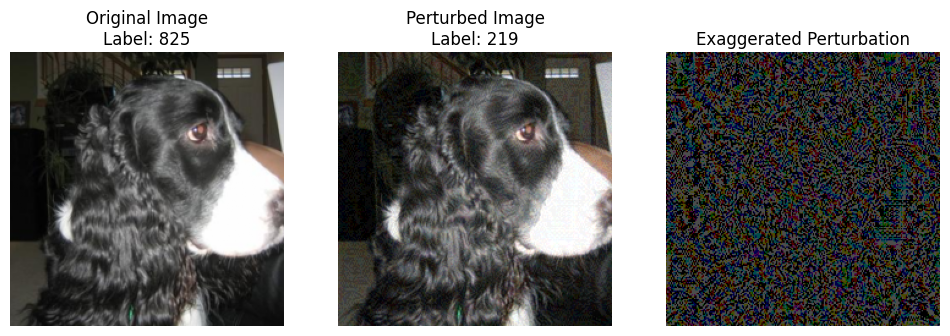

In [29]:
showimages(input_image, perturbed_image, perturbation, original_label, perturbed_label, exaggeration_factor=10)

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already obtained the perturbed_image and original_image from your code
# perturbed_image and original_image are PyTorch tensors, so we need to convert them to NumPy arrays

perturbed_image = perturbed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()  
original_image = input_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
perturbation = perturbation.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Display the images and the difference
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Perturbed Image")
plt.imshow(perturbed_image)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Perturbation")
plt.imshow(perturbation)
plt.axis('off')

plt.show()


ValueError: cannot select an axis to squeeze out which has size not equal to one